In [16]:
import math
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
from datetime import datetime as dt
from IPython.display import display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,9]
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings 
warnings.filterwarnings('ignore')

#### **Loading data**

In [17]:
df = pd.read_excel('https://excelr.s3.nl-ams.scw.cloud/DataScience-Assignments/Assignments/Forecasting/Airlines%2BData.xlsx',sheet_name='Sheet1', header=0, parse_dates=True, index_col=0)
df.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [18]:
print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))


Inference: The Datset consists of 1 features & 96 samples.


#### **Plotting the Timeseries**

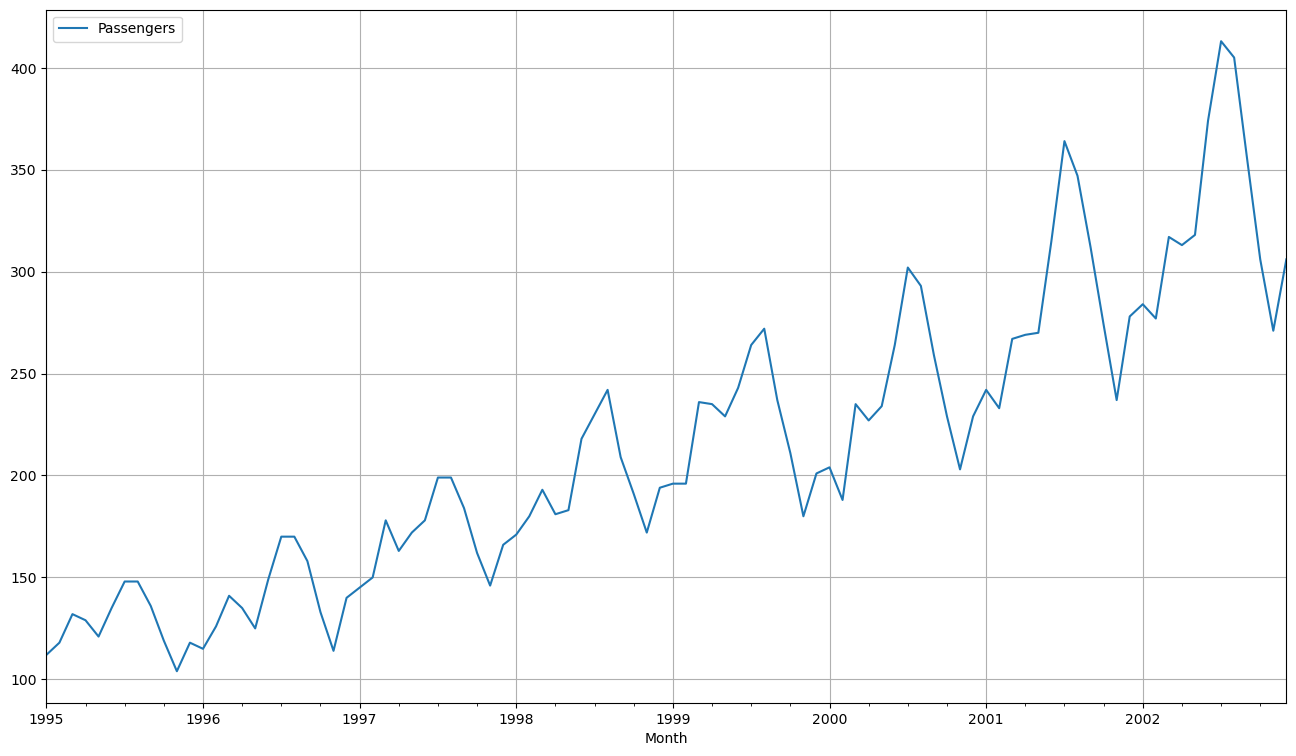

In [19]:
df.plot()
plt.grid()
plt.show()

It's clear from the plot that there is an uptrend in the volumne of Passengers, with some seasonality. Let us perform stationarity check using visual (rolling mean & std) & statistical tests ( Dicky-Fooler's Test) to confirm the same.

#### **Stationary Check**

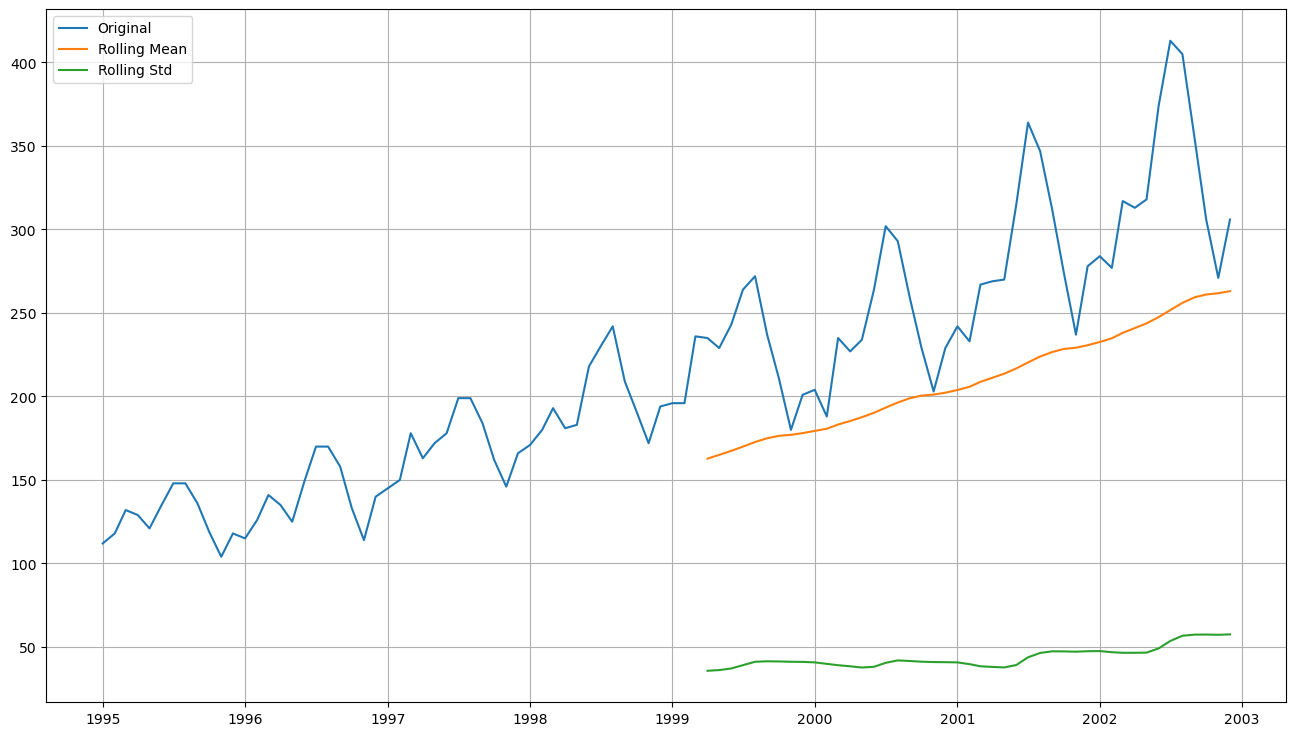

T Statistic            1.340248
P-Value                0.996825
Lags Used             12.000000
Observations Used     83.000000
Critical value 1%     -3.511712
Critical value 5%     -2.897048
Critical value 10%    -2.585713
dtype: float64


In [20]:
def Staionarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52, center=False).std(), label='Rolling Std')
    plt.grid()
    plt.legend()
    plt.show()
    
    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4], index=['T Statistic','P-Value','Lags Used','Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
    
Staionarity_Check(df['Passengers'])

* **T Statistic**: This is a measure of the difference between the sample mean and the null hypothesis mean, divided by the standard error of the mean. A T-statistic of 1.34 suggests that the sample mean is 1.34 standard errors away from the null hypothesis mean.

* **P-Value**: This is the probability of observing a T-statistic as extreme as the one obtained, assuming the null hypothesis is true. In this case, the high P-value of 0.996 suggests that there is a high probability of obtaining a T-statistic as extreme as 1.34 even if the null hypothesis is true.

* **Lags Used**: This is the number of lags included in the regression model.

* **Observations** Used: This is the number of observations used in the regression model.

* Critical value 1%, 5%, 10%: These are the critical values for the test at different significance levels. In this case, they are used to determine whether the T-statistic is significant or not. Since the T-statistic of 1.34 is greater than all the critical values, we can conclude that the result is not significant at any of the tested significance levels.

#### **Decomposing using moving average**

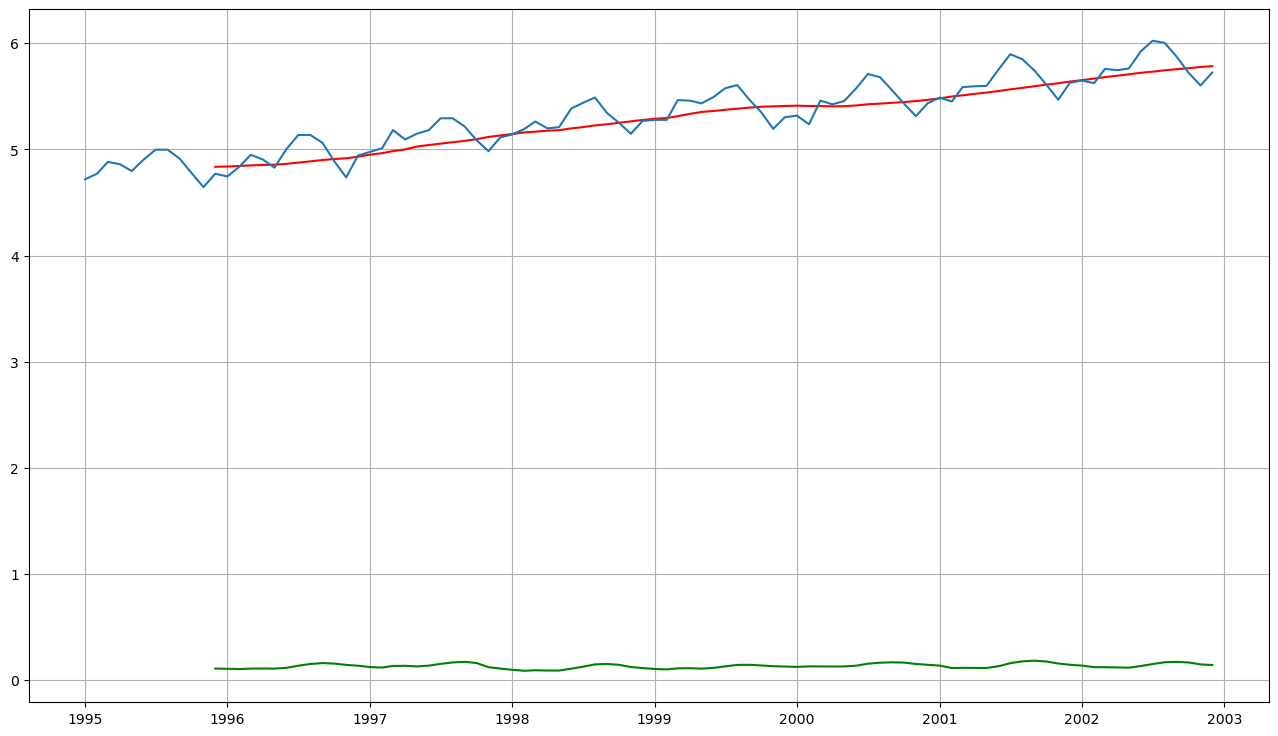

In [21]:
tsl = np.log(df)
ma = tsl.rolling(window=12).mean()
ms = tsl.rolling(window=12).std()

plt.plot(ma, c='r')#, center=False)
plt.plot(ms, c='g')
plt.plot(tsl)
plt.grid()
plt.show()

#### **Stationarity Check for Decomposed Time Series**

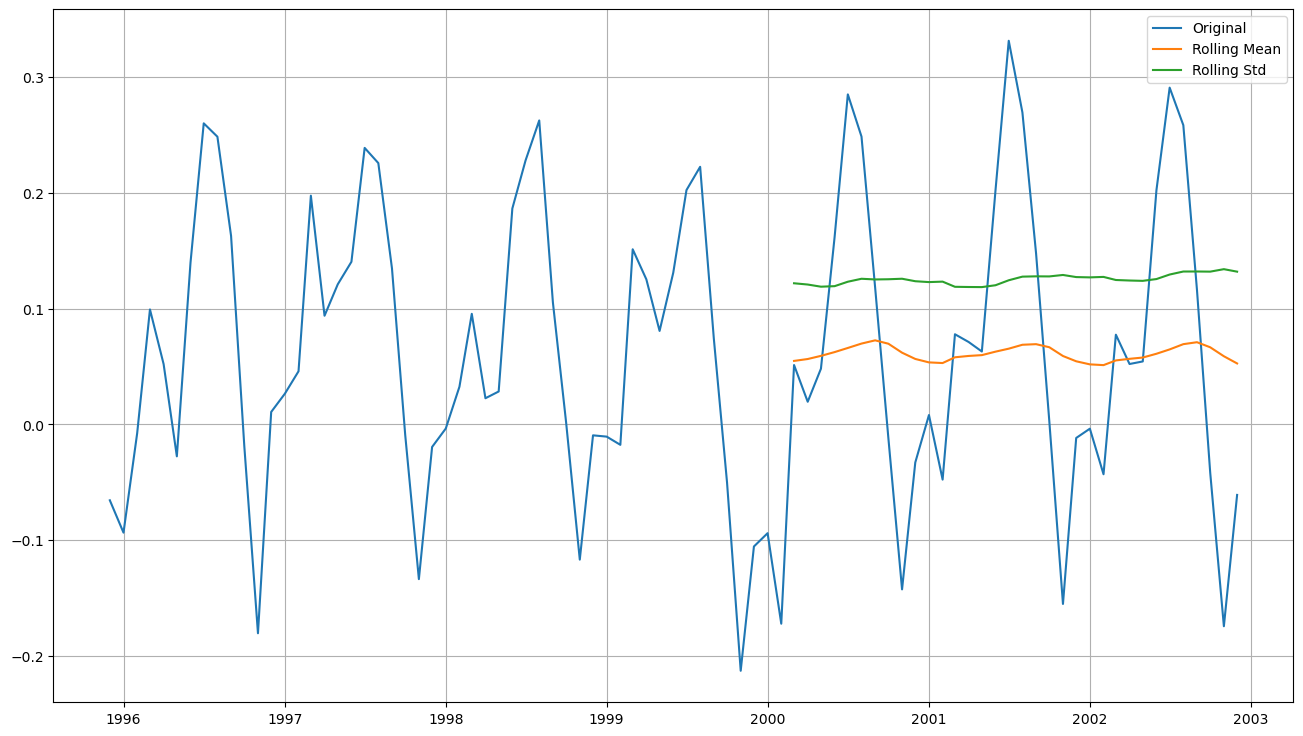

T Statistic           -1.910930
P-Value                0.326937
Lags Used             12.000000
Observations Used     72.000000
Critical value 1%     -3.524624
Critical value 5%     -2.902607
Critical value 10%    -2.588679
dtype: float64


In [22]:
tsl - np.log(df)
ma = tsl.rolling(window=12, center=False).mean()

tslma = tsl - ma
tslma = tslma.dropna()
Staionarity_Check(tslma)

* The **"T Statistic"** value is -1.910930, which suggests that the sample mean is lower than the hypothesized population mean by 1.910930 standard errors. However, without more context it's not clear what the null hypothesis is or what the significance of this difference is.

* The **"P-Value"** of 0.326937 indicates the probability of obtaining a test statistic as extreme as the one observed, assuming that the null hypothesis is true. In this case, since the p-value is higher than the commonly used significance level of 0.05, we fail to reject the null hypothesis.

* The **"Lags Used"** and "Observations Used" values suggest that some kind of time-series analysis may have been performed on a dataset with 72 observations and 12 lags.

* Finally, the **"Critical value"** values provide thresholds for **rejecting the null hypothesis** based on the selected significance level. Since the absolute value of the t statistic (-1.910930) does not exceed any of the critical values, we cannot reject the null hypothesis at the 1%, 5%, or 10% levels of significance.

#### **Plotting ACF / PACF**

#### Auto Correlation Fuction ,q

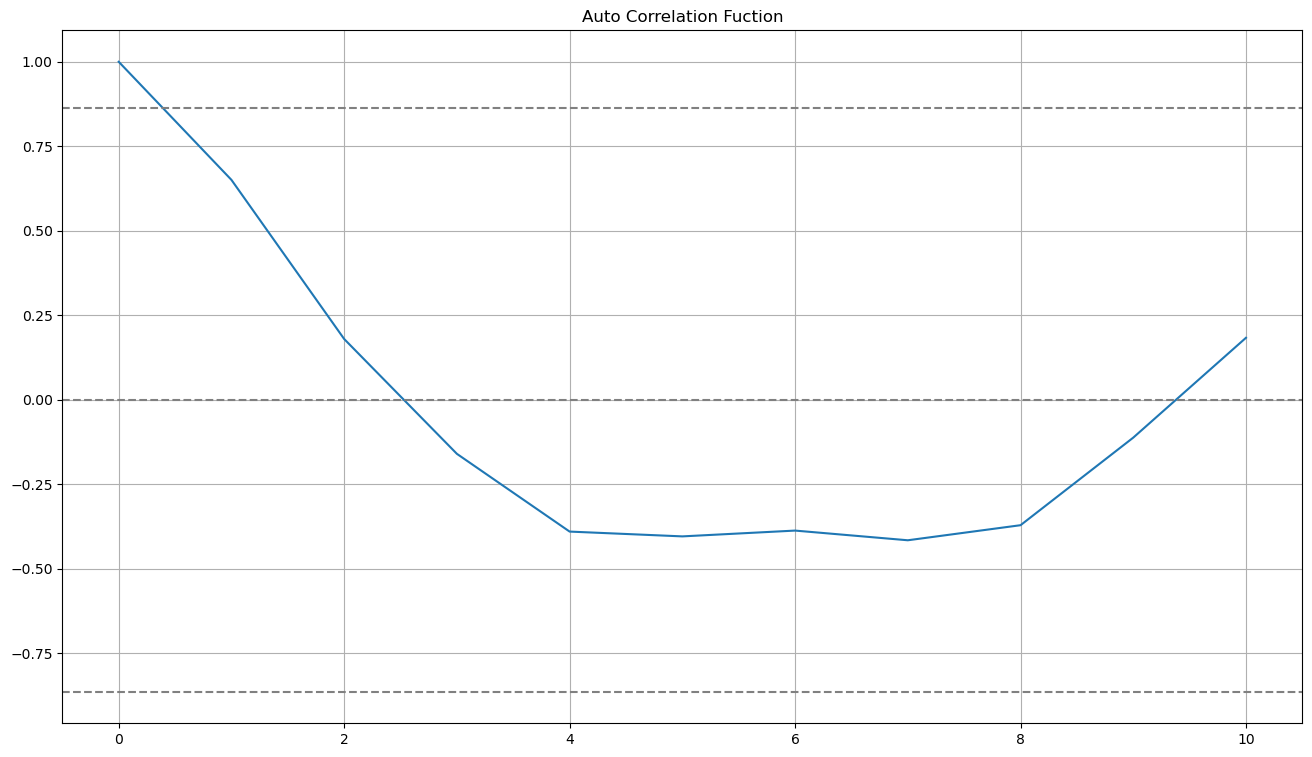

In [23]:
plt.plot(np.arange(acf(tslma, nlags=10,fft=True).shape[0]),acf(tslma, nlags=10, fft=True))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Auto Correlation Fuction')
plt.grid()
plt.show()

* The Graph is describing the results of an Autocorrelation Function (ACF) analysis, which is a statistical method used to study the correlation between observations in a time series. The ACF curve is a graph that shows the correlation between a series and its lagged values.

* The Graph suggests that when **the lag value is between 0 and 1**, t**he ACF curve passes through the upper confidence value**. This indicates that there is a **statistically significant positive correlation between the time series and its lagged values during this period**.

* Furthermore, the Graph concludes that the optimal value of q, which is a parameter used in certain time series models like the ARIMA model, can be either 0 or 1. This means that the number of lagged values to include in the model can be determined based on the ACF curve and its confidence intervals.

#### Partial Auto Correlation Fuction

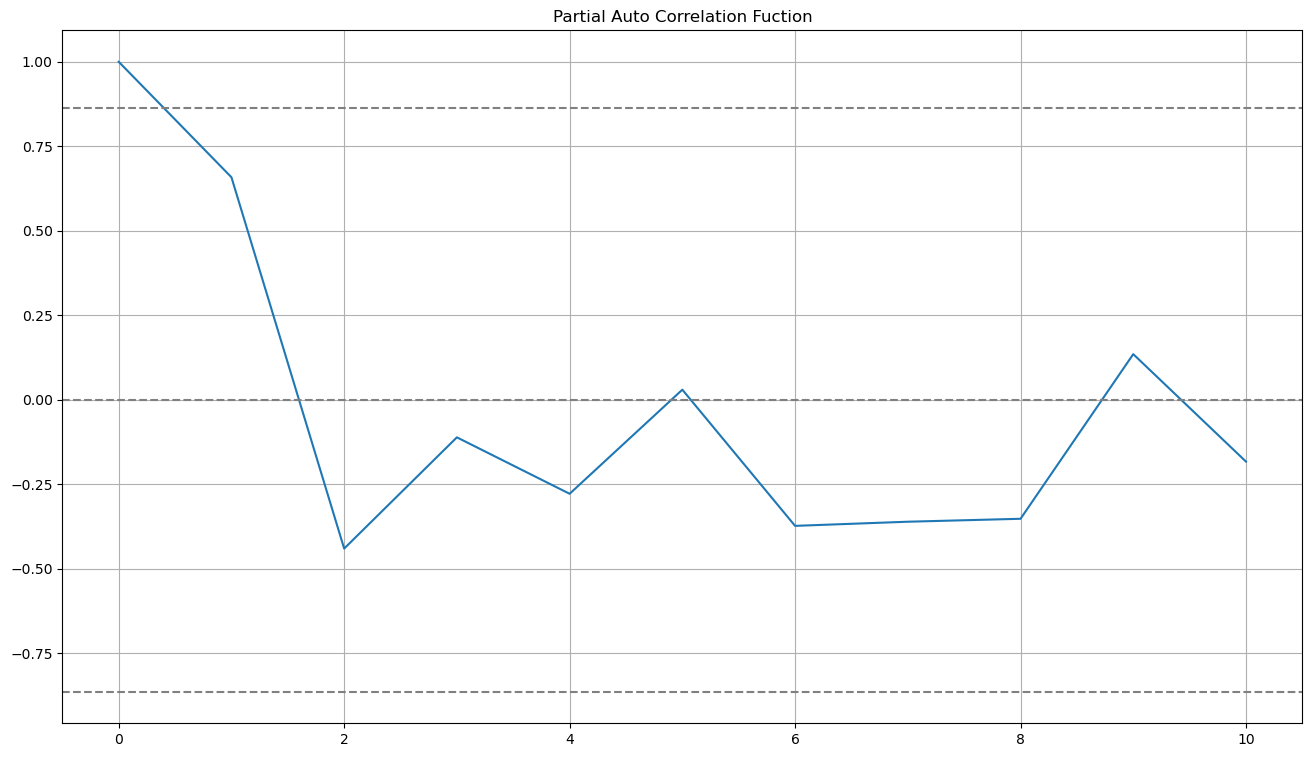

In [24]:
plt.plot(np.arange(pacf(tslma, nlags=10).shape[0]),pacf(tslma, nlags=10))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Partial Auto Correlation Fuction')
plt.grid()
plt.show()

* This Graph is likely referring to a time series analysis technique called the partial autocorrelation function (PACF). The PACF is used to identify the number of lags, or previous values, of a time series that are significantly correlated with the current value after removing the effects of the intermediate lags.

* In this case, the Graph suggests that when plotting the PACF curve for a given time series, the curve drops to 0 at lag values 1 and 2. This indicates that there is significant correlation between the current value and the first two previous values of the time series, and little correlation beyond that.

* Based on this information, the Graph concludes that the optimal value of p, which represents the number of lags to include in a statistical model, can be either 1 or 2. However, the exact choice of p may depend on other factors, such as the goals of the analysis and the specific properties of the time series being studied

### **Building ARIMA Model**

In [25]:
Arima = ARIMA(tslma, order=(1,1,1))
Ar = Arima.fit()

In [26]:
print(Ar.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  75.512
Date:                Wed, 02 Aug 2023   AIC                           -145.025
Time:                        15:04:15   BIC                           -137.732
Sample:                    12-01-1995   HQIC                          -142.093
                         - 12-01-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6213      0.178     -3.498      0.000      -0.969      -0.273
ma.L1          0.8945      0.094      9.524      0.000       0.710       1.079
sigma2         0.0096      0.002      4.589      0.0

* The result is the output of a SARIMAX model (Seasonal Autoregressive Integrated Moving Average with Exogenous variables) that was fit to a time series data of passenger counts over **85 observations** from **December 1995 to December 2002**. 

* The model has an order of **(1, 1, 1) for the Autoregressive**, Integrated, and Moving Average terms respectively. 

* The log-likelihood value for the model is **75.512** and the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) values are **-145.025 and -137.732** respectively.

* The coefficients of the model show that the first lag of the Autoregressive and Moving Average terms are statistically significant with negative and positive values respectively, and the variance of the model residuals is **0.0096**. 

* The Ljung-Box test statistic (Q) for autocorrelation at **lag 1 is 0.01**, indicating no significant autocorrelation in the residuals. 

* The model's Jarque-Bera (JB) test statistic is **3.58**, and the probability of the JB test is **0.17**, which suggests that the model residuals are normally distributed. 

* The Heteroskedasticity test also indicates **no significant** heteroskedasticity in the model residuals.

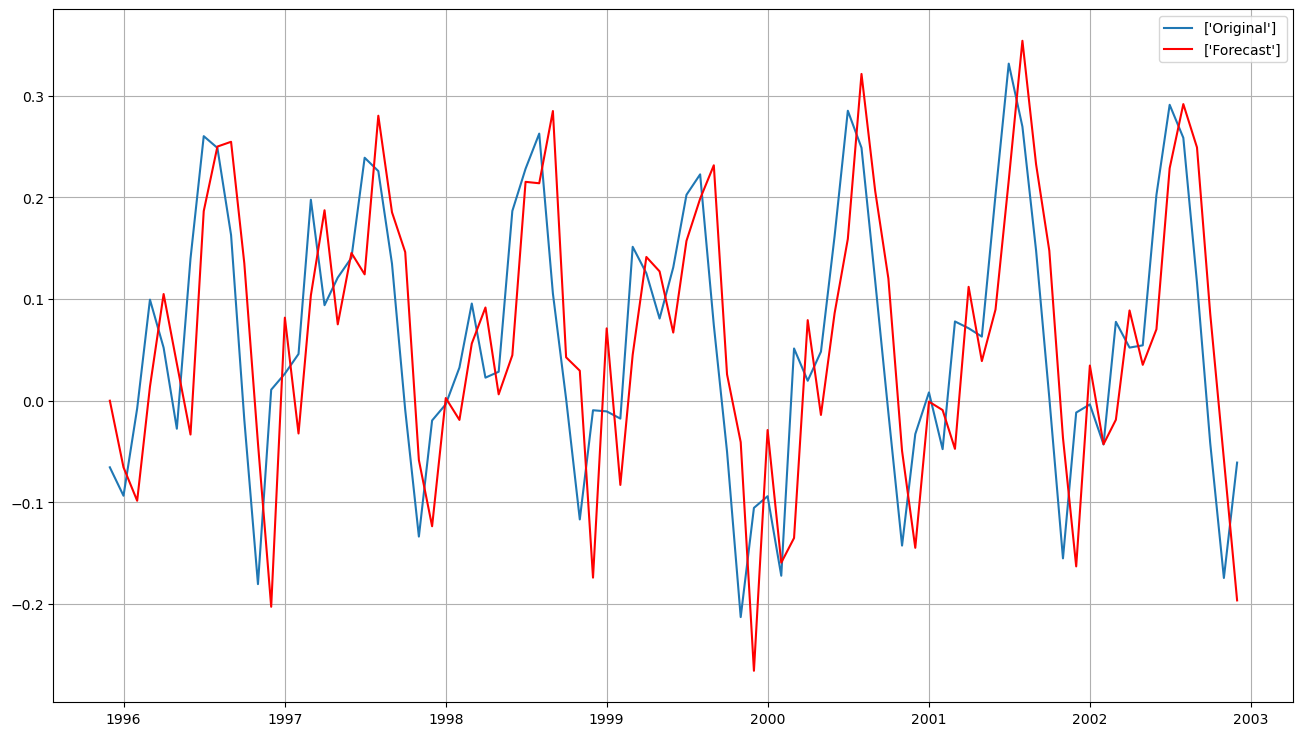

In [27]:
plt.plot(tslma, label=['Original'])
plt.plot(Ar.fittedvalues,c='r', label=['Forecast'])
plt.legend()
plt.grid()

### **Forecasting**

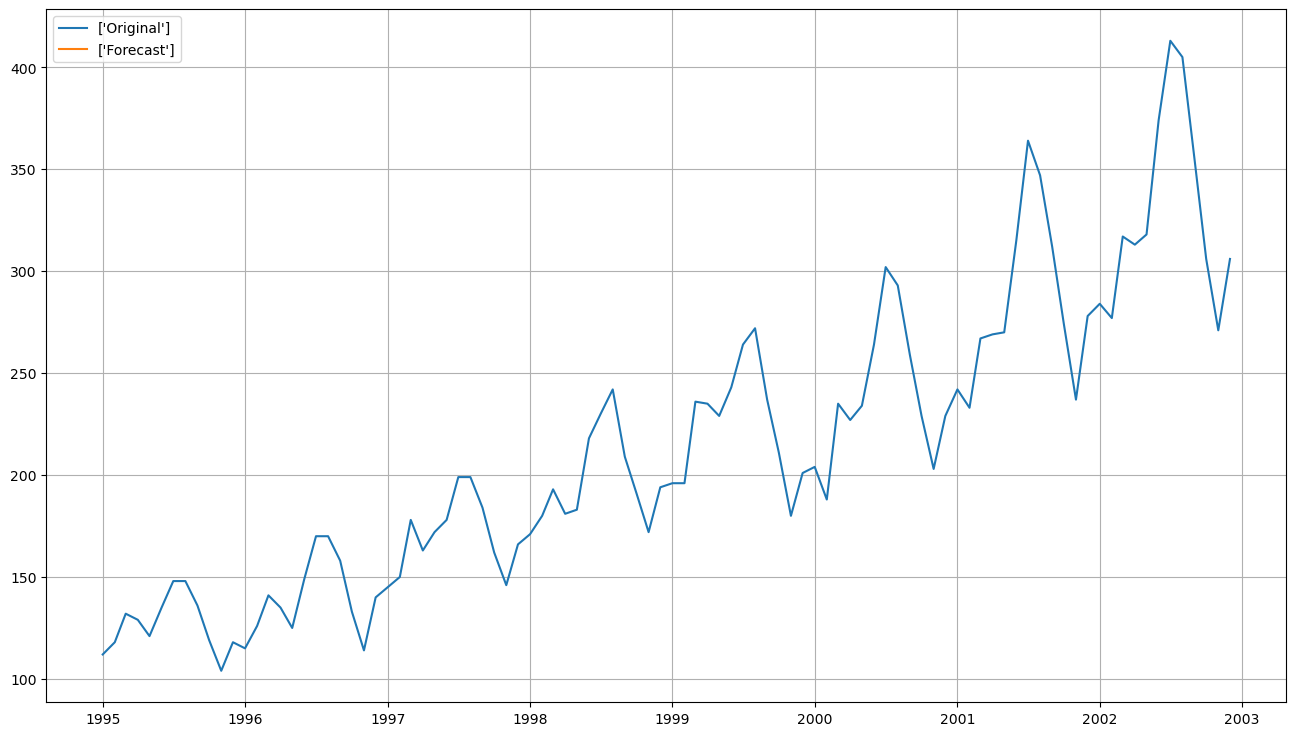

In [28]:
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['Passengers'] = Ar.predict(start =102, end = 131, dynamic= False)

plt.plot(df, label=['Original'])
plt.plot(np.exp(future_df+ma), label=['Forecast'])
plt.grid()
plt.legend()
plt.show()

The Graph suggests that the forecasting model was able to accurately capture the patterns and fluctuations in the time-series data, including both seasonal variations and possible trends. This indicates that the model is likely to produce reliable predictions for future time periods based on the historical patterns it has identified.